## Data preprocess and analysis
This notebook containes medical images loading, analysis and augmentation.
Data comprises tiles extracted from Whole Slide Images (WSI), so WSI reconstruction took place as well.
Reconstruction of a bigger images proved usefull while training - to give model more context - as well as cropping the images, to have more detailes on a smaller instances.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import json
from PIL import Image
import cv2 as cv
from datetime import datetime
from torchvision import models, datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset
import os
from pathlib import Path
import segmentation_models_pytorch as smp

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

SEED = 42

## WSI reconstruction
Let's take a look at one of the whole WSI's

In [3]:
with open(TILE_META_PATH) as f:
    tile_meta = pd.read_csv(f)

df_wsi_4 = tile_meta[tile_meta.source_wsi == 4]
min_max_coord = [df_wsi_4.i.min(), df_wsi_4.j.min(), df_wsi_4.i.max(),  df_wsi_4.j.max()]
col_min, row_min, col_max, row_max = min_max_coord
df_wsi_4.reset_index(drop=True, inplace=True)

wsi = np.zeros(((row_max+512), (col_max+512), 3), dtype=np.uint8)

for i in range(len(df_wsi_4)):
    tile_name = df_wsi_4.id[i] + '.tif'
    tile_path = os.path.join(IMG_PATH, tile_name)

    row_coord = df_wsi_4.j[i]
    col_coord = df_wsi_4.i[i]

    with Image.open(tile_path) as tile:
        wsi[row_coord:(row_coord+512), col_coord:(col_coord+512), :] = np.array(tile)

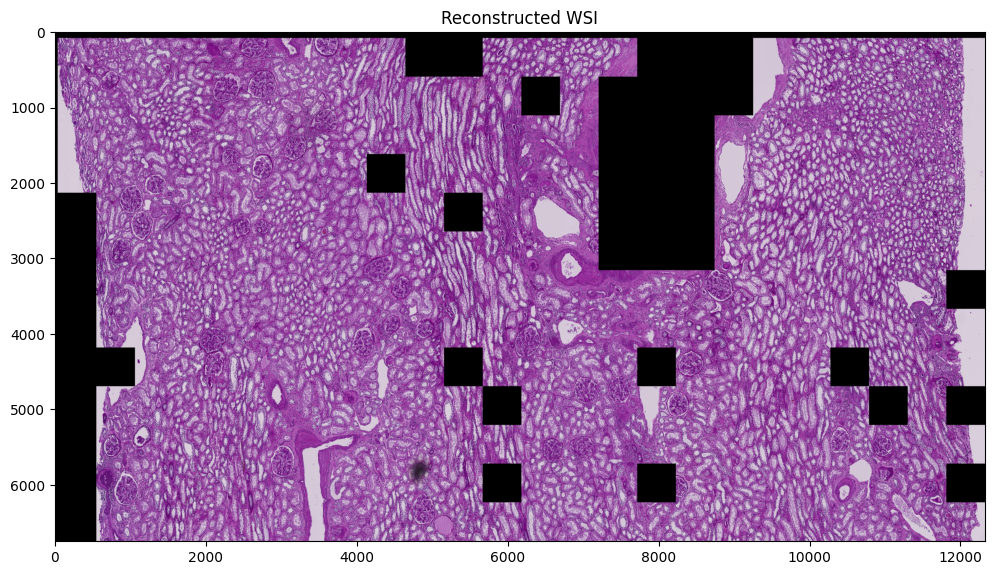

In [4]:
wsi_4_pt1 = wsi[20900:,1500:,:]

plt.figure(figsize=(12,8))
plt.imshow(wsi_4_pt1)
plt.title('Reconstructed WSI')
plt.show()

## Classes analysis

There's 3 classes in this dataset:

1. blood vessel
2. glomerulus
3. unsure

I did not use 'unsure' while training or evaluating model

In [5]:
with open(JSON_FILE) as f:
    polygons = pd.read_json(f, lines=True)

polygons.head()

,id,annotations
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,..."
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,..."
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16..."
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40..."
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14..."


In [6]:
data_anyls = {'id':[], 'blood_vessel_instances':[], 'blood_vessel_pixels':[],
              'glomerulus_instances':[], 'glomerulus_pixels':[],
              'unsure_instances':[], 'unsure_pixels':[]}

types = ['blood_vessel', 'glomerulus', 'unsure']

for id, annotation in polygons.values:
    data_anyls['id'].append(id)
    n_types = {}
    n_pixels = {}
    for dict in annotation:
        n_types[dict['type']] = n_types.get(dict['type'], 0) + 1
        n_pixels[dict['type']] = n_pixels.get(dict['type'], 0) + len(dict['coordinates'][0])

    for key in types:
        data_anyls[key + '_instances'].append(n_types.get(key, 0))
        data_anyls[key + '_pixels'].append(n_pixels.get(key, 0))

data_anyls_df = pd.DataFrame.from_dict(data_anyls).set_index('id')
data_anyls_df.columns = pd.MultiIndex.from_product([types, ['instances', 'pixels']])

In the **table below** we can see ids of tiles, as well as all three classes with corresponding number of instances and number of pixels.

In [7]:
data_anyls_df.head()

blood_vessel        glomerulus           unsure       
                instances pixels  instances pixels instances pixels
id                                                                 
0006ff2aa7cd            8   1588          1   1039         0      0
00168d1b7522            1    199          1    679         0      0
0033bbc76b6b            3    439          0      0         1    275
003504460b3a            7    633          0      0         0      0
004daf1cbe75           10   1252          1    847         0      0

In [8]:
sum_data = data_anyls_df.sum(axis=0)

sum_data

blood_vessel  instances      16054
              pixels       2540194
glomerulus    instances        567
              pixels        453953
unsure        instances        897
              pixels        206405
dtype: int64

In [9]:
print('Blood vessel/Glomerulus classes Ratio:\n')
print(f'Instance: {sum_data.blood_vessel.instances/sum_data.glomerulus.instances},\n\
Pixels: {sum_data.blood_vessel.pixels/sum_data.glomerulus.pixels}')

Blood vessel/Glomerulus classes Ratio:

Instance: 28.31393298059965,
Pixels: 5.595720261789216


We can see that the target 'blood vessel' class instances are much smaller but pixel-wise are numerous.

## Data augmentation
To give model more context, I took not a single tile, but a larger 9x9(tiles) image, using provided metadata for each image.
For data augmentation, I made a random crop, rotation, color jitter, etc.

In [10]:
class TileNineByNine(Dataset):

    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH):

        with open(tile_meta_path) as f:
            self.tile_meta = pd.read_csv(f)

        with open(json_file) as f:
            self.polygons = pd.read_json(f, lines=True)

        self.images_path = images_path

    def __len__(self):
        return len(self.polygons)

    def transformation(self, image, mask):

        need_crop = (image.shape[0] > 512)

        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)

        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])

        flip = np.random.random()

        flip_v = np.random.random()
        pad = np.random.random()
        jitter = np.random.random()


        if jitter > 0.5:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)

        image = TF.rotate(image,rotate_params)

        if flip > 0.7:
            image = TF.hflip(image)

        if flip_v > 0.7:
            image = TF.vflip(image)

        mask_img = TF.rotate(mask_img,rotate_params)

        if flip > 0.7:
            mask_img = TF.hflip(mask_img)

        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)

        input_image_size = (512, 512)

        if need_crop:
            crop_size = np.random.choice(range(412, 812)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)

        else:
            crop_size = np.random.choice(range(412, 512)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)


        mask = (np.array(mask_img))

        return (image, mask)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        img_name = self.polygons.iloc[index, 0]

        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')

        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)

        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]

        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()

        init_row = row_coord - 512

        is_blank_flag = False
        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):

                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]

                if image_small_name.empty:
                    is_blank_flag = True
                    image_large = np.array(image)

                    mask_large = np.zeros((512, 512), dtype=np.uint8)

                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)

                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)

                    break

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')

                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)

                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()
                mask = np.zeros((512, 512), dtype=np.uint8)

                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)

                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)

                mask_large[y:y+512,x:x+512] = mask

                x += 512
                init_col += 512

            if is_blank_flag:
                break
            y += 512
            init_row += 512


        image_large, mask_large = self.transformation(image_large, mask_large)

        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()

        image_large = norm(torch.tensor(image_large.astype(np.float32)))

        return image_large, mask_large.astype(np.float32)

In [11]:
dataset = TileNineByNine()

train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(SEED))

In [12]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)

    return(masked_img)

def img_denorm(x: np.ndarray) -> np.ndarray:
    """
    :param: normalized image with transforms.Normilize
    :return: numpy array with values 0 to 255
    """
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)

    return x

Let's take a look at augmented images.

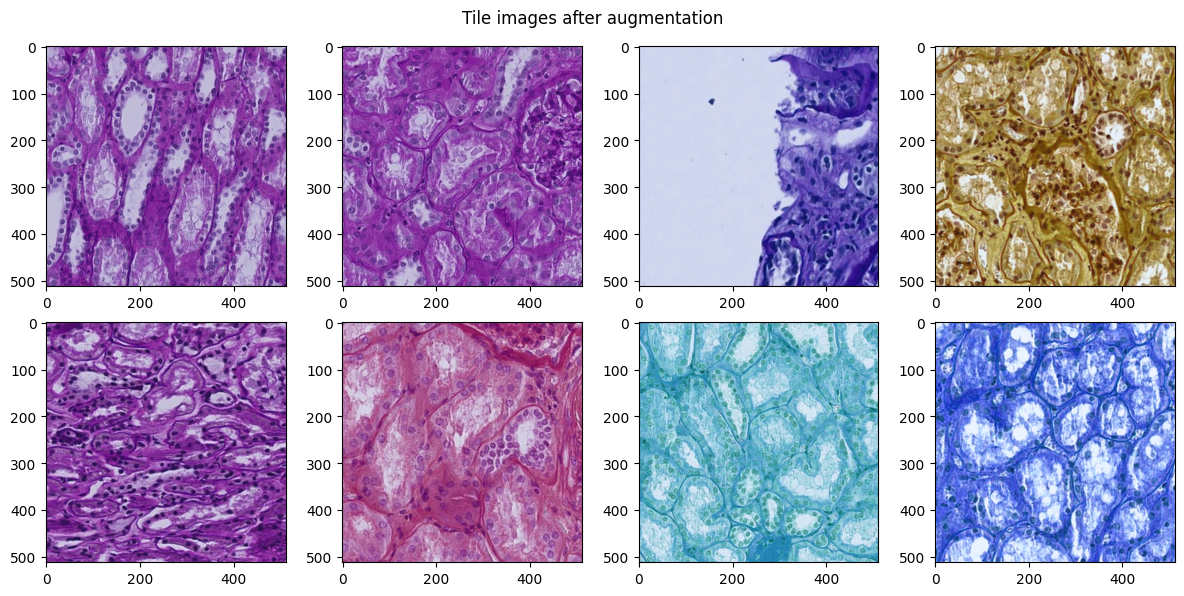

In [13]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(dataset))

        image = dataset[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Tile images after augmentation')
plt.show()

Next, let's look at images with segmentation masks, provided with dataset.

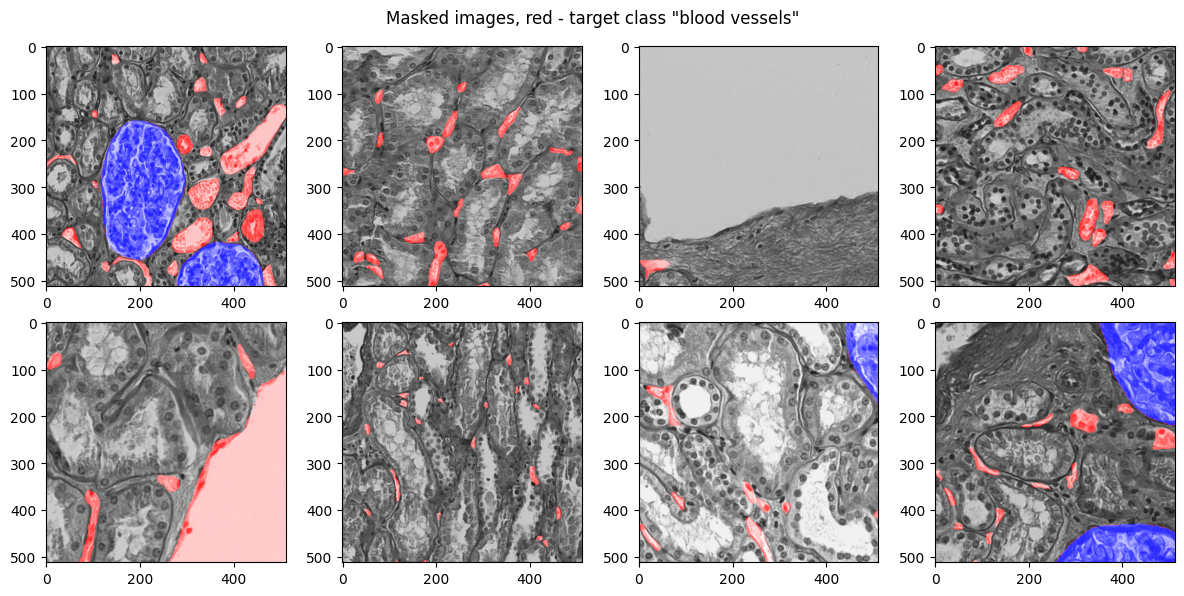

In [14]:
fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(dataset))

        img, msk = dataset[r_num]
        img, msk = img.numpy().transpose((1,2,0)), msk
        img, msk = img_denorm(img), msk.astype(np.uint8)
        mask_classes = np.zeros((512, 512, 2), dtype=np.uint8)
        mask_classes[:,:,0] = (msk==1)
        mask_classes[:,:,1] = (msk>1)

        if mask_classes.max():
            mask_classes = mask_classes*(255//mask_classes.max())

        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        bnw_img = np.stack((img,)*3, axis=-1)
        bnw_img[:,:,0] = cv.bitwise_or(bnw_img[:,:,0], mask_classes[:,:,0])
        bnw_img[:,:,2] = cv.bitwise_or(bnw_img[:,:,2], mask_classes[:,:,1])

        axs[i, j].imshow(bnw_img, cmap='gray')

fig.suptitle('Masked images, red - target class "blood vessels"')
plt.show()

The red ones are <b>blood vessels</b> - target class we want the model to predict, and the blue ones are <b>glomerulus</b>. As we can see, glomerulus are much larger than blood vessel, and on the initial tiles they got cut pretty significantly, leading to worse predictions. After taking a larger view, the model learned second class much faster and made better predictions.